In [1]:
# import all needed libraries
import pandas as pd
import numpy as np
import numpy.random as nr
import sys
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import feature_selection as fs

In [2]:
# load the processed dataset
data = pd.read_csv('data_preprocessed.csv')

In [3]:
# define a random state number for all random operations - ensures reproducibility of all results
random_state_num = 0

In [4]:
data.shape

(7040, 25)

In [5]:
label_name = ['CO2_EM_PC']
feature_names = [
'CountryCode',
'ALT_NUCL_EN_PERC',
'AIR_TRANS_FREIGHT',
'COMB_REN_WASTE_PERC',
'CEREAL_YIELD',
'ELEC_PROD_COAL_PERC',
'ELEC_PROD_HYDRO_PERC',
'ELEC_PROD_NAT_GAS_PERC',
'ELEC_PROD_NUCL_PERC',
'ELEC_PROD_OIL_PERC',
'ELEC_PROD_RENW_SRC_PERC',
'EN_USE_PC',
'FOSSIL_FUEL_EN_CONS_PERC',
'FUEL_IMPORT_PERC',
'GDP_GROWTH_PERC',
'GDP_PC',
'POP_GROWTH_PERC',
'POP_URBAN_AGG',
'URBAN_POP_TOTAL',
'URBAN_POP_GROWTH',
'METHANE_EM',
'NO2_EM'
]


In [6]:
# convert into nympy arrays (required for scikit-learn models)
features = np.array(data[feature_names])
labels =  np.array(data[label_name])

In [7]:
# split into training and testing subsets
nr.seed(1)
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                            labels,
                                                                            test_size=0.4,
                                                                            random_state=random_state_num)

In [8]:
# Set folds for cross validation for the feature selection
nr.seed(1)
feature_folds = ms.KFold(n_splits=4, shuffle = True, random_state=random_state_num)

# Define the model
rf_selector = RandomForestRegressor(random_state=random_state_num) 

# Define an objects for a model for recursive feature elimination with CV
nr.seed(1)
selector = fs.RFECV(estimator = rf_selector, cv = feature_folds, scoring = 'r2', n_jobs=-1)

selector = selector.fit(features_train, np.ravel(labels_train))
selector.support_

print("Feature ranking after RFECV:")
print(selector.ranking_)

# print the important features
ranks_transform = list(np.transpose(selector.ranking_))
chosen_features = [i for i,j in zip(feature_names,ranks_transform) if j==1]
print("Chosen important features:")
print(chosen_features)

Feature ranking after RFECV:
[1 1 1 1 2 1 1 1 5 1 3 1 1 4 6 1 1 1 1 1 1 1]
Chosen important features:
['CountryCode', 'ALT_NUCL_EN_PERC', 'AIR_TRANS_FREIGHT', 'COMB_REN_WASTE_PERC', 'ELEC_PROD_COAL_PERC', 'ELEC_PROD_HYDRO_PERC', 'ELEC_PROD_NAT_GAS_PERC', 'ELEC_PROD_OIL_PERC', 'EN_USE_PC', 'FOSSIL_FUEL_EN_CONS_PERC', 'GDP_PC', 'POP_GROWTH_PERC', 'POP_URBAN_AGG', 'URBAN_POP_TOTAL', 'URBAN_POP_GROWTH', 'METHANE_EM', 'NO2_EM']


In [9]:
# assign only the important variables to the features array of both training and testing dataset
features_train_reduced = selector.transform(features_train)
features_test_reduced = selector.transform(features_test)

print("Training subset shape before the recursive feature elimination:")
print(features_train.shape)
print("Training subset array shape after the recursive feature elimination:")
print(features_train_reduced.shape)
print("Test subset array shape after the recursive feature elimination:")
print(features_test_reduced.shape)

Training subset shape before the recursive feature elimination:
(4224, 22)
Training subset array shape after the recursive feature elimination:
(4224, 17)
Test subset array shape after the recursive feature elimination:
(2816, 17)


In [10]:
# Define value ranges for each hyperparameter
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

# Create the hyperparameter grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [11]:
# define the cross-validation folds for the hyperparameter tuning
nr.seed(1)
inside_folds = ms.KFold(n_splits=5, shuffle = True, random_state=random_state_num)

# Define the random forest regressor model object
rf_tuner = RandomForestRegressor(random_state=random_state_num)

# Perform a randomized search on the grid
nr.seed(1)
rf_model = ms.RandomizedSearchCV(estimator=rf_tuner, param_distributions = param_grid,
                                 random_state=random_state_num, refit=True,
                                 cv=inside_folds, scoring = 'r2', return_train_score=True, n_jobs=-1)

In [12]:
# Fit the grid search model object with cross-validation on the data
rf_model.fit(features_train_reduced, np.ravel(labels_train))

# Print the best parameter value
best_n_estimators = rf_model.best_estimator_.n_estimators
best_max_features = rf_model.best_estimator_.max_features

print("best number of estimators:")
print(best_n_estimators)
print("best max features:")
print(best_max_features)
print("max depth:")
print(rf_model.best_estimator_.max_depth)
print("min samples split")
print(rf_model.best_estimator_.min_samples_split)
print("min samples leaf")
print(rf_model.best_estimator_.min_samples_leaf)

/Users/itorongo/Personal/USN/Second Semester/Data Science/Project/CS4020-ML-CO2-Emission-Prediction/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best number of estimators:
1600
best max features:
sqrt
max depth:
20
min samples split
2
min samples leaf
1


In [13]:
# pick the model with the best hyperparameter combination for further analysis
rf_best_model = rf_model.best_estimator_

In [14]:
# define the cross-validation folds for the evaluation
nr.seed(1)
outside_folds = ms.KFold(n_splits=10, shuffle = True, random_state=random_state_num)

# Evaluate the model on the training subset with cross-validation
nr.seed(1)
cv_eval = cross_val_score(rf_best_model, features_train_reduced, labels_train, cv = outside_folds, n_jobs=-1)

print('Mean R2 score of all CV folds = %4.3f' % np.mean(cv_eval))
print('Standard deviation of the R2 score over all folds = %4.3f' % np.std(cv_eval))
print('R2 score for each fold:')

# print the R2 score for each fold
for i, j in enumerate(cv_eval):
    print('Fold %2d    %4.3f' % (i+1, j))

/Users/itorongo/Personal/USN/Second Semester/Data Science/Project/CS4020-ML-CO2-Emission-Prediction/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/itorongo/Personal/USN/Second Semester/Data Science/Project/CS4020-ML-CO2-Emission-Prediction/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/itorongo/Personal/USN/Second Semester/Data Science/Project/CS4020-ML-CO2-Emission-Prediction/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d a

Mean R2 score of all CV folds = 0.980
Standard deviation of the R2 score over all folds = 0.009
R2 score for each fold:
Fold  1    0.982
Fold  2    0.970
Fold  3    0.987
Fold  4    0.982
Fold  5    0.979
Fold  6    0.961
Fold  7    0.989
Fold  8    0.987
Fold  9    0.990
Fold 10    0.978


In [16]:
# make predictions from the features of the testing subset
predictions = rf_best_model.predict(features_test_reduced)

# import the functions for the metrics evaluation
from sklearn.metrics import r2_score, mean_squared_error

# calculate the metrics basing on the predicted and true values for the test subset
r2 = r2_score(y_true=labels_test, y_pred=predictions)
mse = mean_squared_error(y_true=labels_test, y_pred=predictions)
rmse = np.sqrt(mse)

print("R2=", r2)
print("Mean Squared Error: MSE=", mse)
print("Root Mean Squared Error: RMSE=", rmse)

R2= 0.9790159827309658
Mean Squared Error: MSE= 0.5986716080312239
Root Mean Squared Error: RMSE= 0.7737387207780311


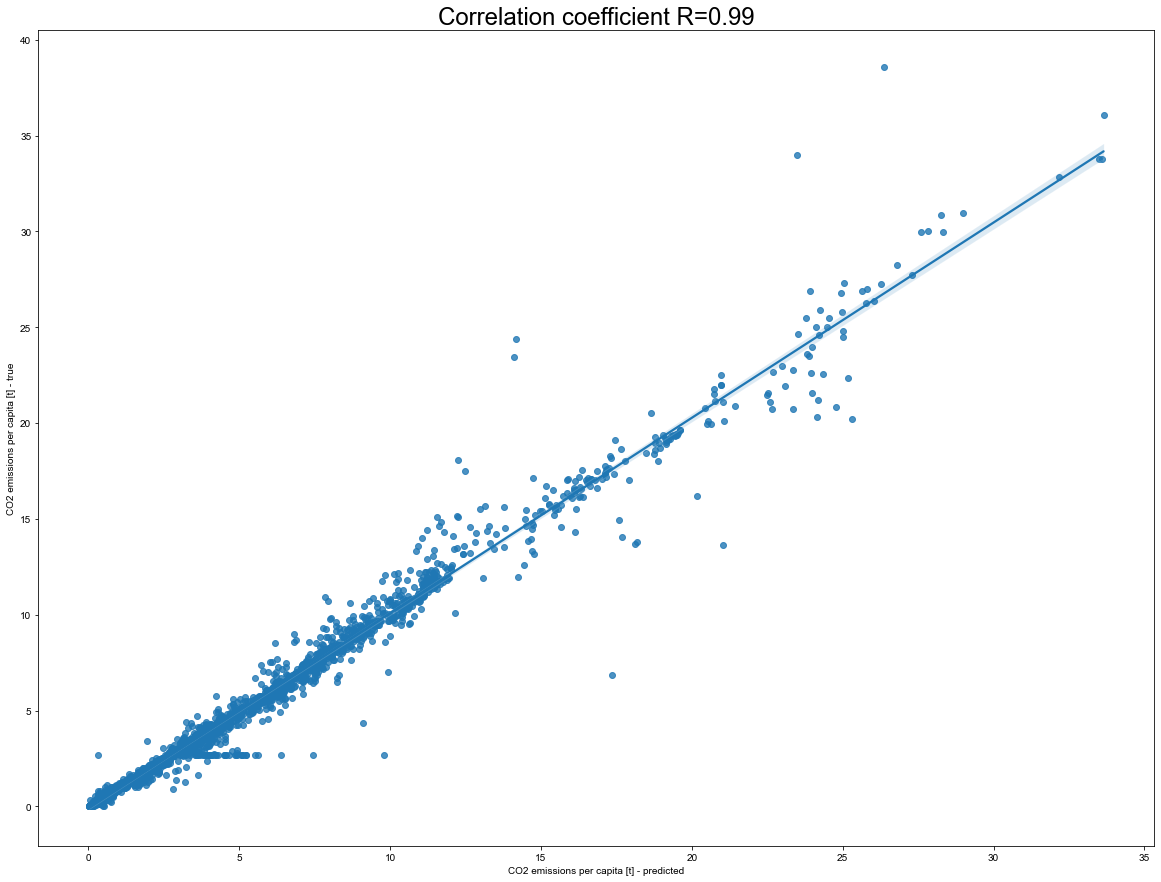

In [17]:
# plot predicted vs true values of the test subset

f,ax=plt.subplots(figsize=(20,15))
sns.set(font_scale=2)

sns.regplot(x=predictions, y=np.transpose(labels_test)[0,:], fit_reg=True)
plt.xlabel("CO2 emissions per capita [t] - predicted")
plt.ylabel("CO2 emissions per capita [t] - true")
plt.title("Correlation coefficient R="+str(round(np.corrcoef(predictions,np.transpose(labels_test)[0,:])[0,1],2)))
plt.show()

In [18]:
input_features = ['CountryCode', 'ALT_NUCL_EN_PERC', 'AIR_TRANS_FREIGHT', 'COMB_REN_WASTE_PERC', 'ELEC_PROD_COAL_PERC', 'ELEC_PROD_HYDRO_PERC', 'ELEC_PROD_NAT_GAS_PERC', 'ELEC_PROD_OIL_PERC', 'EN_USE_PC', 'FOSSIL_FUEL_EN_CONS_PERC', 'GDP_PC', 'POP_GROWTH_PERC', 'POP_URBAN_AGG', 'URBAN_POP_TOTAL', 'URBAN_POP_GROWTH', 'METHANE_EM', 'NO2_EM']
input_features

['CountryCode',
 'ALT_NUCL_EN_PERC',
 'AIR_TRANS_FREIGHT',
 'COMB_REN_WASTE_PERC',
 'ELEC_PROD_COAL_PERC',
 'ELEC_PROD_HYDRO_PERC',
 'ELEC_PROD_NAT_GAS_PERC',
 'ELEC_PROD_OIL_PERC',
 'EN_USE_PC',
 'FOSSIL_FUEL_EN_CONS_PERC',
 'GDP_PC',
 'POP_GROWTH_PERC',
 'POP_URBAN_AGG',
 'URBAN_POP_TOTAL',
 'URBAN_POP_GROWTH',
 'METHANE_EM',
 'NO2_EM']

In [19]:
user_input = [153, 
              2.40177406211193, #ALT_NUCL_EN_PERC
              4.06835119546078, #AIR_TRANS_FREIGHT
              11.1869668311768, #COMB_REN_WASTE_PERC
              0.0, #ELEC_PROD_COAL_PERC
              68.2627042346144, #ELEC_PROD_HYDRO_PERC
              17.7197748428362, #ELEC_PROD_NAT_GAS_PERC
              14.0175209225494, #ELEC_PROD_OIL_PERC
              968.2793688020530, #EN_USE_PC
              75.5589175262015, #FOSSIL_FUEL_EN_CONS_PERC
              16054.490513096200, #GDP_PC
              0.874378499265389, #POP_GROWTH_PERC
              29.7091935086727, #POP_URBAN_AGG
              88.14400000000000, #URBAN_POP_TOTAL
              0.8868577738237520, #URBAN_POP_GROWTH
              29056.75, #METHANE_EM
              12683.6490142 #NO2_EM
             ]
result = rf_best_model.predict([user_input])[0]
result

5.424288933669769

In [24]:
import pickle
# open a file, where you ant to store the data
file = open('co2_emission_rf.pkl', 'wb')

# dump information to that file
pickle.dump(rf_best_model, file)